# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта**
1. Проведите исследовательский анализ набора фотографий.
2. Подготовьте данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.

**Описание данных**

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/). Они находятся в папке `/datasets/faces/`. 
В вашем распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`. 
Извлечь данные из папки вам поможет новый метод [ImageDataGenerator](https://keras.io/preprocessing/image/) —`flow_from_dataframe(dataframe, directory, ...)`.

## Исследовательский анализ данных

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
PROJECT_ROOT_PATH = '/datasets/faces/'

In [3]:
def load_dataset(dataset_name):
    return pd.read_csv(PROJECT_ROOT_PATH + dataset_name)

In [4]:
data = load_dataset('labels.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
data.real_age.nunique()

97

In [8]:
data.real_age.sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        93,  94,  95,  96,  97, 100])

In [9]:
with pd.option_context('display.max_rows', None):
    print(data.real_age.value_counts())

30     317
25     315
27     229
26     226
28     217
23     213
24     211
18     193
16     193
19     180
22     179
20     178
32     174
40     167
29     164
17     163
34     156
50     156
1      149
35     147
37     144
33     144
21     143
31     129
15     128
14     125
38     124
36     122
39     107
4      101
42      99
41      98
44      96
47      93
2       88
45      88
5       87
43      85
13      79
52      76
60      75
49      74
46      74
51      70
6       68
7       67
48      66
12      56
58      54
11      51
55      51
70      50
53      45
10      45
54      44
8       44
56      41
59      41
57      37
65      36
9       34
80      31
62      28
61      28
3       25
64      23
90      21
63      20
66      18
69      18
67      18
75      17
68      15
72      13
85      12
73      10
71      10
77       8
84       8
76       7
74       6
79       6
87       6
94       5
82       5
89       4
86       3
78       3
81       3
83       3
88       3

In [10]:
data.real_age.value_counts().head(10).sort_index()

16    193
18    193
19    180
23    213
24    211
25    315
26    226
27    229
28    217
30    317
Name: real_age, dtype: int64

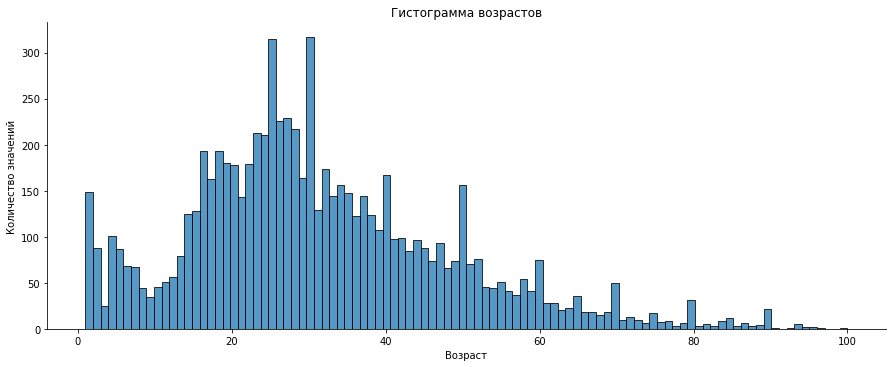

In [11]:
sns.displot(
    data.real_age,
    bins=100,
    height=5,
    aspect=2.5
)
plt.ylabel('Количество значений')
plt.xlabel('Возраст')
plt.title('Гистограмма возрастов');

Из анализа графика можно сделать следующие заметки, выводы:
 - приближённо (из визуальной оценки) можно сказать большая часть значений имеет распределение Пуасона, или Гамма распределение;
    - но при этом на завышенный хвост слева в диапазоне значений от 0 до 10;
    - и так же на гистограмме выделяются пиковые значения на 25, и далее начиная с 30 на значениях кратных 10. С чем свяязаны кратные 10 пиковые знаения предположить трудно, возможно это свяязанно с особенностями сбора данных для текущего датасета;
 - дополнительно можно отметить, что схожесть с распределением Пуассона коррелирует с требование заказчика использовать как метрику качества MAE. 

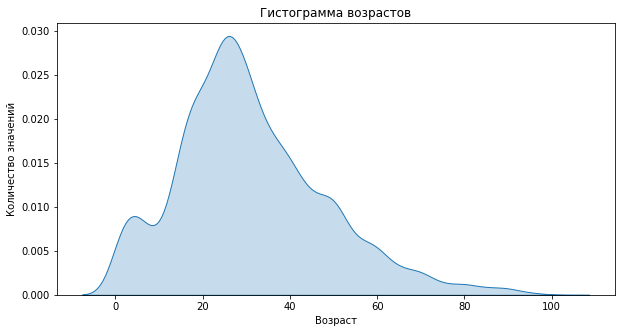

In [12]:
plt.figure(figsize=(10, 5))
sns.kdeplot(
    data.real_age,
    shade=True
)
plt.ylabel('Количество значений')
plt.xlabel('Возраст')
plt.title('Гистограмма возрастов');

In [13]:
datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1/255.
)

In [14]:
datagen_flow = datagen.flow_from_dataframe(
    data,
    directory=PROJECT_ROOT_PATH+'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    class_mode='raw',
    batch_size=16,
    seed=12345
)

Found 7591 validated image filenames.


In [15]:
features, target = datagen_flow.next()

In [16]:
features.shape

(16, 150, 150, 3)

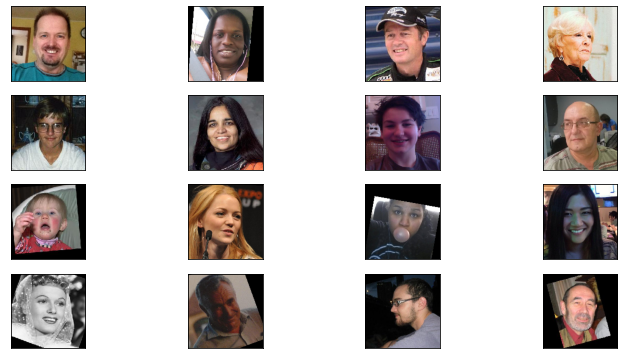

In [17]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Наблюдения и выводы:
 - датасет содержит 7590 изображений;
 - исследованный датасет состоит из цветных фотографий (3-х канальные изображения)
 - так же на отрисованных фотографиях видно, что часть фотографий предположительно развернута на некоторый угол предположительно относительно исходного состояния снимка;
 - далее анализ описания исходного датасета с сайта [https://chalearnlap.cvc.uab.cat/dataset/26/description/](ChaLearn Looking at People) позволяет сделать вывод, что в исследуемом датасете представлены уже обработанные снимки, то есть предварительно на исходных снимках бвла проведена детекция лиц и приведение фотографий к виду - "квадратные изображения с лицом в центре  фиксированного (в среднем) размера и с фиксированным (в среднем) отступом до краёв изображения". То есть в датасете представлены уже предобработанные изображения с лицами  и можео уточнить главную задачу исследования "Определение возраста покупателей по лицу".


К вопросу о том, как результаты исследования повлияют на обучение модели:
 - поскольку снимки обработаны, проведена детекция лиц, то это должно значительно улучшить качетсво обученной модели;
    - дополнительно можно отметить, что в данном исследовании применение к изображениям аугментации типа вращения или сдвигов нецелесоображно, это только ухудшит качество модели;
 - данных не много - 7590 изображений, скорость обучения должна быть высокой



## Обучение модели

```python

import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

RANDOM_STATE = 732568


def load_dataset():
    dataset_name = 'labels.csv'
    try:
        data =  pd.read_csv('/datasets/faces/' + dataset_name)
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/faces/' + dataset_name)
    return data


def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        load_dataset(),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        class_mode='raw',
        batch_size=16,
        seed=RANDOM_STATE,
        subset='training'
    )
    
    return train_datagen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )

    test_datagen_flow = test_datagen.flow_from_dataframe(
        load_dataset(),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        class_mode='raw',
        batch_size=16,
        seed=RANDOM_STATE,
        subset='validation'
    )
    
    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model


def train_model(model,
                train_datagen_flow,
                val_datagen_flow,
                batch_size=None,
                epochs=10,
                steps_per_epoch=None,
                validation_steps=None
               ):

    model.fit(
        train_datagen_flow,
        validation_data=val_datagen_flow,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 46s - loss: 224.4257 - mean_absolute_error: 10.9253 - val_loss: 342.9608 - val_mean_absolute_error: 13.6771
Epoch 2/10
356/356 - 36s - loss: 72.2090 - mean_absolute_error: 6.5428 - val_loss: 161.3138 - val_mean_absolute_error: 9.5748
Epoch 3/10
Epoch 4/10
356/356 - 36s - loss: 35.7291 - mean_absolute_error: 4.6343 - val_loss: 82.5112 - val_mean_absolute_error: 6.9561
356/356 - 39s - loss: 22.6275 - mean_absolute_error: 3.6960 - val_loss: 107.1904 - val_mean_absolute_error: 8.0850
Epoch 5/10
356/356 - 36s - loss: 16.8015 - mean_absolute_error: 3.1236 - val_loss: 109.5704 - val_mean_absolute_error: 7.8054
Epoch 6/10
356/356 - 36s - loss: 13.3510 - mean_absolute_error: 2.7872 - val_loss: 73.6579 - val_mean_absolute_error: 6.4501
Epoch 7/10
356/356 - 36s - loss: 11.5702 - mean_absolute_error: 2.5834 - val_loss: 83.7761 - val_mean_absolute_error: 6.8157
Epoch 8/10
356/356 - 35s - loss: 10.1922 - mean_absolute_error: 2.4033 - val_loss: 72.8511 - val_mean_absolute_error: 6.3799
Epoch 9/10
356/356 - 36s - loss: 9.9240 - mean_absolute_error: 2.3591 - val_loss: 100.3583 - val_mean_absolute_error: 7.8484
Epoch 10/10
356/356 - 36s - loss: 9.8124 - mean_absolute_error: 2.3687 - val_loss: 77.8791 - val_mean_absolute_error: 6.5379
119/119 - 9s - loss: 77.8791 - mean_absolute_error: 6.5379
Test MAE: 6.5379

```

## Анализ обученной модели

 - для обученияя была использована стандартная модель с архитектурой ResNet50;
 - модель обучалась 10 зпох;
 - на GPU время обучения одной эпохи составило не более 46 секунд;
 - по логам обучения модели можно отметить, что модель достигла требуемого качества уже после 3-ей эпохи обучения;
 - после обучения значение метрики MAE на тесте составило `6.5379`.